# Working with Data

In [ ]:
using DataFrames, RDatasets, CSV, JLD, HDF5, Query, Match
using Plots, PyPlot, GR, StatsBase, Distributions
using GLM, HypothesisTests, KernelDensity, Clustering

using Statistics, Printf, Dates, DelimitedFiles

## Basic Input/Output

### Terminal I/O

In [ ]:
 write(stdout, "Help ME!!!\n")

In [ ]:
write(stderr,"Error messages should come here.")

In [ ]:
#= 
read(stdin) will not work in a Jupyter notebook

It is possible to use a terminal

Use File/Open and choose New->Terminal from the pulldowmn menu
Run the Julia REPL

TIP: 
On my system (OSX) I have setup the following symbolic link in my 
~/bin folder (which is on the executable path)

julia -> /Applications/Julia-1.0.app/Contents/Resources/julia/bin/julia

Try some of the following:- (CR => carriage return, ^D => control-D)

read(stdin,Char)        - type a letter + CR
read(stdin,String)      - type a string + ^D (CR is part of the string)

read(stdin,Int32)       - type a number + CR
read(stdin,UInt32)      - type same number + CR
readline(stdin)         -   "    "    "       "


In [ ]:
# However readline will work in Julia
a = readline()

![](Figures/Figure-6-1.png)

<p>How to explain what we see?</p>
* Reading as UInt8 gives a clue, 0x34333231, is the ASCII codes for the number 4321, i.e. the number input by reversed.
* So when specifying Int64, 875770417 is this byte stream interpreted as an integer.

---

In [ ]:
# Because readline() works in Jupyter this is OK.

function getInt()
    s = chomp(readline())
    try
        parse(eltype(1),s)
    catch ex 
        println(ex, "\nCan't convert $s to an integer")       
    end
end

getInt()

In [ ]:
# As is this

function getFloat()
    s = chomp(readline())
    try
        parse(eltype(1.1),s)
    catch ex
        println(ex, "\nCan't convert $s to a float")
    end
end

getFloat()


In [ ]:
bb = Array{UInt8}(undef,0)     # This will not work in a notebook

The following call reads 4 bytes into the byte array bb

- The size of the array is extended by readbytes!()
- If more bytes are input the required an error is generated by the remainder
- If less bytes are input, the rest of the array is filled with nulls
- If the number of bytes is omitted the default is the (current) size of the array

![](Figures/Figure-6-2.png)

---

## Working with disk files

### Textfiles

In [ ]:
#=

Opening a file has to main syntax:

open(filename::AbstractString; keywords...)
open(filename::AbstractString, [mode::AbstractString])

If neither keywords of a mode string are given then the default is to open the file for a read

=#

# Discuss diffence between s1*s2 vs String(s1,s2)

flip = ENV["HOME"]*"/PacktPub/Alice/jabberwocky.txt";
isfile(flip)


In [ ]:
# Classic paradigm
# This prints the first 4 lines of the Jabberwocky 
# We need the let/end because of the new scoping rules
let
    fin = open(flip)
    k = 0;
    while !eof(fin)
        ln = readline(fin)
        k = k+1
        (k > 4) ? break : println(ln)
    end
    close(fin)
end


In [ ]:
# Because file processing is a common process Julia has an alternative syntax
# Note jabber4.txt is just the first verse of the Jabberwocky, save us having to count 
# and break to reduce the output

flp4 = ENV["HOME"]*"/PacktPub/Alice/jabber4.txt";

open(flp4) do pn4
  while !eof(pn4)
     println(readline(pn4))
  end
end


In [ ]:
# The file handle is not defined after the loop, so does not need to be closed.
julia> eof(pn4)

In [ ]:
#= 
Conveniently we can read all a file in to a variable without explicitly opening it
Note that at the data is returned as a byte array (the file may be a binary)
=#
# For a text file we need to convert it

jb4 = String(read(flp4))

# NB: This needs to be split of "\n"s to reproduce the familiar first verse

In [ ]:
# There is an additional format:  open(function, filename)

capitalize(f::IOStream) = chomp(uppercase(String(read(f))));
split(open(capitalize, flp4),"\n")

# We need the chomp() to remove the "\n" in the last line, 
# otherwise a 5-element array would be returned with the last element "".


In [ ]:
# In the previous chapter we used Perl to reverse a lines of a poem.
# Here is a native Julia version

open( flp4) do pn4
    while !eof(pn4)
        println(reverse(chomp(readline(pn4))))
    end
end

# Again we need to chomp the line, reverse it and use println
# Otherwise the "\n" would come at the front

### Text processing

In [ ]:
# We can also emulate the 'wc' or or wc() approaches from previously
# In this routine only the words or counted
# Actually this is the most difficult, counting lines and characters are easy

# We will split on white space and also pinctation marks

const PUNCTS =  [' ','\n','\t','-','.',',',':',';','!','?','\'','"'];

# The routine returns a hash (Dict) with the words found as keys and the count as the values,

function wordcount(text)
  wds = split(lowercase(text), PUNCTS; keepempty = false)
  d = Dict()
  for w = wds
     d[w] = get(d,w,0)+1
  end
  return d
end


In [ ]:
# Test it on our 4 line Jabberwocky
wordcount(String(read(flp4)))

# Most words only occur once but 'and' & 'the' have a higher frequency

In [ ]:
# Wordcount returns a dictionary of the words in a file
#
# So if we collect the values (i.e the counts) and sum them ...
# ... this gives a total for the file.

using Printf
AliceDir = ENV["HOME"]*"/PacktPub/Alice/";  # Note the convenient trailing '/'

# Filter to look just a the '.txt' files in the Alice directory
# We can collect all the value sof the Dict in an array and sum it for the total i the file
#=
for fname in filter!(r"\.txt$", readdir(AliceDir))
  open(AliceDir*fname) do f
    n = sum(collect(values(wordcount(String(read(f))))))
    @printf "%s: %d\n" fname n
  end
end
=#

for fname in readdir(AliceDir)
  if match(r"\.txt$", fname) != nothing
    open(AliceDir*fname) do f
      n = sum(collect(values(wordcount(String(read(f))))))
      @printf "%s: %d\n" fname n
    end
  end
end


In [ ]:
# Look at some of the characters in the Hunting of the Snark
# All of the ones in the boat begin with a 'B'

snarkDict = wordcount(String(read(AliceDir*"hunting-the-snark.txt")))

wds = ["baker","banker","barrister","beaver","bellman","boots","butcher"];
for w in wds
  @printf "%12s  => %4d\n" w snarkDict[w]
end

### Binary files

In [ ]:
# Set the correct directory and open the Juliaset
# Read the first line for the "magic" number

cd(ENV["HOME"]*"/PacktPub/Chp06"); 
img = open("Files/juliaset.pgm");
magic = chomp(readline(img))

In [ ]:
#=
Check is is a PGM file
If so pick up the next line to get the image size
Open an 'output' file
This will be another PGM file of the same size ...
... so we can write 'magic' and 'params' to the output
=#
if magic == "P5"
  out = open("Files/jsetinvert.pgm", "w");
  println(out, magic);
  params = chomp(readline(img));  # => "800 400 255"
  println(out, params);
# Params splits into strings, we need integers
  (wd, ht, pmax) = parse.(Int64,split(params));
# Create a byte array and read ALL the image data in one call.
  np = wd*ht;
  buf = Array{UInt8,1}(undef,np)
  readbytes!(img, buf, np);
# Invert the gra
  bufX = [UInt8(255 - buf[i]) for i = 1:np]
  write(out,bufX))
  close(out);
else
  error("Not a NetPBM grayscale file")
end

close(img)

![](Figures/Figure-6-3a.png)

#### This code is NOT in the book, since the image created is in colour

In [ ]:
# Define a pseudocolor filter
#
function pseudocolor(pix)
  if pix < 64
    pr = UInt8(0); pg = UInt8(0); pb = UInt8(4*pix)
  elseif pix < 128
    pr = UInt8(0); pg = UInt8(min(4*(pix - 64),255)); pb = UInt8(255)
  elseif pix < 192
    pr = UInt8(0); pg = UInt8(255); pb = UInt8(min(4*(192 - pix),255))
  else
    pr = UInt8(min(4*(pix - 192),255))
    pg = UInt8(min(4*(256 - pix),255))
    pb = UInt8(0)
  end
  return (pr, pg, pb) 
end

pseudocolor(0xa1)


In [ ]:
cd(ENV["HOME"]*"/PacktPub/Chp06"); 
img = open("Files/juliaset.pgm");
magic = chomp(readline(img))

In [ ]:
#=
Same logical as before
Except:-
1. Changing magic number from P5 => P6
2. Applying the pseudocolor filter
3. Writing 3 bytes for each (r,g,b)
=#
if magic == "P5"
  out = open("Files/jsetcolor.ppm", "w");
  println(out, "P6");
  params = chomp(readline(img));  # => "800 400 255"
  println(out, params);
  (wd, ht, pmax) = parse.(Int64,split(params));
  np = wd*ht;
  buf = Array{UInt8,1}(undef,np)
  readbytes!(img, buf, np);
  for j = 1:np
    (r,g,b) = pseudocolor(buf[j]);
    write(out,UInt8(r)); write(out,UInt8(g)); write(out,UInt8(b))
  end
  close(out);
else
  error("Not a NetPBM grayscale file")
end

close(out)
close(img)

![](Figures/Figure-6-3b.png)

![](jsetcolor.ppm)

---

## CSV and Delimited files


In [153]:
# Start by working with some Apple stock prices
using CSV, Statistics, Printf

cd(ENV["HOME"]*"/PacktPub/Chp06/")
aaplcsv = "Files/aapl.csv"; isfile(aaplcsv)

true

In [154]:
# The CSV.File routine returns the schema
# Notice the unions as the data may have missing values
aapl = CSV.File(aaplcsv)

CSV.File("Files/aapl.csv", rows=8336):
Tables.Schema:
 :Date                  Union{Missing, Date}   
 :Open                  Union{Missing, Float64}
 :High                  Union{Missing, Float64}
 :Low                   Union{Missing, Float64}
 :Close                 Union{Missing, Float64}
 :Volume                Union{Missing, Float64}
 Symbol("Ex-Dividend")  Union{Missing, Float64}
 Symbol("Split Ratio")  Union{Missing, Float64}
 Symbol("Adj. Open")    Union{Missing, Float64}
 Symbol("Adj. High")    Union{Missing, Float64}
 Symbol("Adj. Low")     Union{Missing, Float64}
 Symbol("Adj. Close")   Union{Missing, Float64}
 Symbol("Adj. Volume")  Union{Missing, Float64}

In [155]:
# Look at the fields comprising the datastructure.
fieldnames(typeof(aapl))

(:names, :types, :name, :io, :parsinglayers, :positions, :originalpositions, :currentrow, :lastparsedcol, :lastparsedcode, :kwargs, :pools, :strict, :silencewarnings)

In [156]:
# We are at the first position
aapl.currentrow

Base.RefValue{Int64}(1)

In [157]:
# Print the first 5 rows
k = 0;
for r in aapl
    @printf "%s : %.2f\n" r.Date (r.Close - r.Open)
    global k = k + 1
    if k > 5 break end
end

2013-12-31 : 6.85
2013-12-30 : -2.94
2013-12-27 : -3.73
2013-12-26 : -4.20
2013-12-24 : -2.22
2013-12-23 : 2.09


In [222]:
# Check that we are now at the 6th row.
aapl.currentrow

Base.RefValue{Int64}(6)

In [158]:
# It is possible to 'pipe' the CSV.File structure to a Dataframe
# Useful to sort the dataframe in place
#
using DataFrames
df = aapl |> DataFrame

sort!(df)

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
,Dates…⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,1980-12-12,28.75,28.88,28.75,28.75,2.0939e6,0.0,1.0,3.37658,3.39185,3.37658,3.37658,1.67512e7
2,1980-12-15,27.38,27.38,27.25,27.25,785200.0,0.0,1.0,3.21568,3.21568,3.20041,3.20041,6.2816e6
3,1980-12-16,25.38,25.38,25.25,25.25,472000.0,0.0,1.0,2.98079,2.98079,2.96552,2.96552,3.776e6
4,1980-12-17,25.88,26.0,25.88,25.88,385900.0,0.0,1.0,3.03951,3.05361,3.03951,3.03951,3.0872e6
5,1980-12-18,26.62,26.75,26.62,26.62,327900.0,0.0,1.0,3.12642,3.14169,3.12642,3.12642,2.6232e6
6,1980-12-19,28.25,28.38,28.25,28.25,217100.0,0.0,1.0,3.31786,3.33313,3.31786,3.31786,1.7368e6
7,1980-12-22,29.62,29.75,29.62,29.62,166800.0,0.0,1.0,3.47876,3.49403,3.47876,3.47876,1.3344e6
8,1980-12-23,30.88,31.0,30.88,30.88,209600.0,0.0,1.0,3.62674,3.64084,3.62674,3.62674,1.6768e6
9,1980-12-24,32.5,32.62,32.5,32.5,214300.0,0.0,1.0,3.81701,3.8311,3.81701,3.81701,1.7144e6


In [160]:
# Dataframes can be queried with the "Queryverse"
# Of which more later
using Query, Dates

In [161]:
x = @from i in df begin
    @where i.Date >= Date(2013,12,20)
    @select {i.Date, i.Open, i.High, i.Low, i.Close}
    @collect DataFrame
end

,Date,Open,High,Low,Close
,Date⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,2013-12-20,545.43,551.61,544.82,549.02
2,2013-12-23,568.0,570.72,562.76,570.09
3,2013-12-24,569.89,571.88,566.03,567.67
4,2013-12-26,568.1,569.5,563.38,563.9
5,2013-12-27,563.82,564.41,559.5,560.09
6,2013-12-30,557.46,560.09,552.32,554.52
7,2013-12-31,554.17,561.28,554.0,561.02


---

### DLM Files


In [226]:
using DelimitedFiles

In [227]:
cd(ENV["HOME"]*"/PacktPub/Chp06/")
ukhptsv = "Files/UKH-Prcs.tsv"; isfile(ukhptsv)

true

In [228]:
(ukhpData,ukhpHead) = readdlm(ukhptsv, '\t'; header=true)
ukhpHead

1×10 Array{AbstractString,2}:
 "Inner London"  "Outer London"  "North East"  …  "South East"  "South West"

In [229]:
(ukd1, ukd2) = size(ukhpData)

(240, 10)

In [230]:
typeof(ukhpData)

Array{Float64,2}

In [231]:
using PyPlot

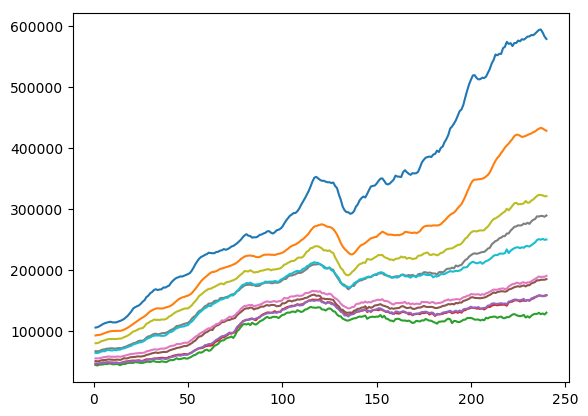

In [232]:
t = collect(1:ukd1);

for i in 1:10
  plot(t,ukhpData[:,i])
end

---

In [233]:
aaplcsv = "Files/aapl.csv"; isfile(aaplcsv)

true

In [234]:
(aaplData,aaplHead) = readdlm(aaplcsv, ','; header=true)
aaplHead

1×13 Array{AbstractString,2}:
 "Date"  "Open"  "High"  "Low"  "Close"  …  "Adj. Close"  "Adj. Volume"

In [235]:
aaplData[1:10, 1:6]

10×6 Array{Any,2}:
 "2013-12-31"  554.17  561.28  554.0   561.02  7.9673e6 
 "2013-12-30"  557.46  560.09  552.32  554.52  9.0582e6 
 "2013-12-27"  563.82  564.41  559.5   560.09  8.0673e6 
 "2013-12-26"  568.1   569.5   563.38  563.9   7.286e6  
 "2013-12-24"  569.89  571.88  566.03  567.67  5.9841e6 
 "2013-12-23"  568.0   570.72  562.76  570.09  1.79038e7
 "2013-12-20"  545.43  551.61  544.82  549.02  1.55862e7
 "2013-12-19"  549.5   550.0   543.73  544.46  1.14396e7
 "2013-12-18"  549.7   551.45  538.8   550.77  2.02094e7
 "2013-12-17"  555.81  559.44  553.38  554.99  8.2108e6 

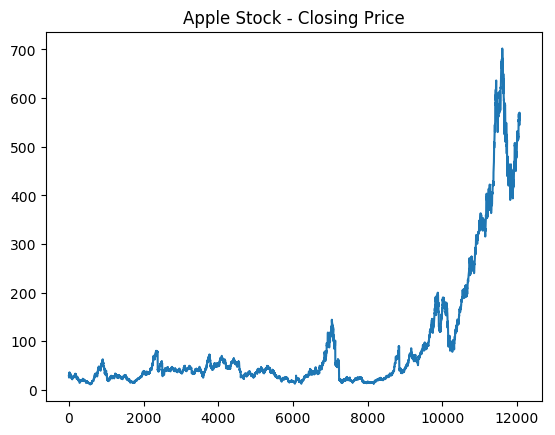

PyObject <matplotlib.text.Text object at 0x13b3fdf90>

In [236]:
using Dates, PyPlot

d0 = Date("2000-01-01")
aaplDate  = reverse(Date.(aaplData[:,1]))
aaplOpen = reverse(Float64.(aaplData[:,2]))
aaplClose = reverse(Float64.(aaplData[:,5]))

const NAAPL = length(aaplDate)
aapl_days = zeros(Int64, NAAPL)

d0 = aaplDate[1]
dt = [(aaplDate[i] - d0).value for i = 1:NAAPL]

plot(dt, aaplClose)
title("Apple Stock - Closing Price")


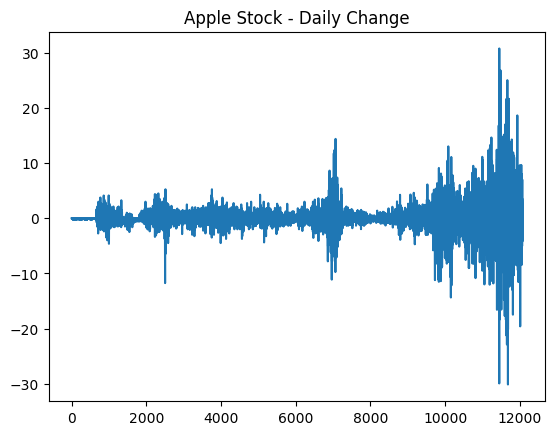

PyObject <matplotlib.text.Text object at 0x13b8a0c10>

In [237]:
aaplDifs = [(aaplClose[i] - aaplOpen[i]) for i = 1:NAAPL]
plot(dt,aaplDifs)
title("Apple Stock - Daily Change")

---

## HDF5 and JLD files


In [2]:
using JLD, HDF5

In [6]:
cd(ENV["HOME"]*"/PacktPub/Chp06/")
h5file = "Files/mydata.h5"
aa = [u + v*rand() for u = 0.5:0.5:10.0, v = 0.5:0.5:6.0]

h5open(h5file, "w") do f
    write(f, "aa", aa) 
end

# Alternatively, we can say "@write h5file aa" or else h5write(h5file,"aa",aa)

In [7]:
# This can be read back without the h5open statement (similar to h5write)
# Also we can create a slice of the file on-the-fly

bb = h5read(h5file, "aa", (2:3:14, 4:3:10))

5×3 Array{Float64,2}:
 2.49545  3.73017  3.55605
 3.02282  3.69234  4.83512
 4.57292  6.13872  5.82451
 6.63335  7.49806  6.99261
 8.67941  9.10232  8.12539

In [248]:
aapljld = "Files/aapl.jld";
rm(aapljld, force=true)

jldopen(aapljld, "w") do fid
  write(fid,"aaplDate",aaplDate)
  write(fid,"aaplClose",aaplClose)
  write(fid,"aaplDifs",aaplDifs)
end

isfile(aapljld)

true

In [249]:
fid = jldopen(aapljld, "r")

Julia data file version 0.1.2: Files/aapl.jld

In [250]:
aaDate = read(fid, "aaplDate")
aaDifs = read(fid, "aaplDifs")
close(fid)

In [251]:
fid = jldopen("Files/myaapl.jld", "w")
g = g_create(fid, "aapl")
g["aaplDate"]  = aaplDate
g["aaplClose"] = aaplClose
g["aaplDifs"]  = aaplDifs

dump(fid)

JLD.JldFile
  plain: HDF5File
    id: Int64 72057594037927950
    filename: String "Files/myaapl.jld"
  version: VersionNumber
    major: UInt32 0x00000000
    minor: UInt32 0x00000001
    patch: UInt32 0x00000002
    prerelease: Tuple{} ()
    build: Tuple{} ()
  toclose: Bool true
  writeheader: Bool true
  mmaparrays: Bool false
  compatible: Bool false
  compress: Bool false
  h5jltype: Dict{Int64,Type}
    slots: Array{UInt8}((16,)) UInt8[0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00]
    keys: Array{Int64}((16,)) [4670935568, 4507873712, 4507873568, 4515670544, 4629039984, 4629037632, 4629037632, 4507765136, 4670978096, 4507765136, 4841826160, 4629039088, 4629039312, 4629039088, 4512113376, 4629037632]
    vals: Array{Type}((16,))
      1: #undef
      2: #undef
      3: #undef
      4: #undef
      5: #undef
      ...
      12: #undef
      13: #undef
      14: #undef
      15: #undef
      16: #undef
    ndel: Int64 0
    count: 

In [ ]:
g = fid["aapl"]
adf = g["aaplDifs"]
close(fid)

# Alternatively: adf = fid["aapl/aaplDifs"]

---

In [9]:
using LightXML
xdoc = parse_file("Files/books.xml");

┌ Info: Precompiling LightXML [9c8b4983-aa76-5018-a973-4c85ecc9e179]
└ @ Base loading.jl:1189


In [12]:
xtop = LightXML.root(xdoc);
println(LightXML.name(xtop));

catalog


In [13]:
xdoc

<?xml version="1.0" encoding="utf-8"?>
<catalog>
   <book id="bk101">
      <author>Gambardella, Matthew</author>
      <title genre="Computing">XML Developer's Guide</title>
      <price currency="GBP">44.95</price>
      <publish_date>2000-10-01</publish_date>
      <description>An in-depth look at creating applications with XML.</description>
   </book>
   <book id="bk102">
      <author>Ralls, Kim</author>
      <title genre="Fantasy">Midnight Rain</title>
      <price currency="GBP">5.95</price>
      <publish_date>2000-12-16</publish_date>
      <description>A former architect battles corporate zombies, an evil sorceress, and her own childhood to become queen of the world.</description>
   </book>
   <book id="bk103">
      <author>Corets, Eva</author>
      <title genre="Fantasy">Maeve Ascendant</title>
      <price currency="GBP">5.95</price>
      <publish_date>2000-11-17</publish_date>
      <description>After the collapse of a nanotechnology society in England, the young sur

In [14]:
using Printf

for c in child_nodes(xtop)
    if is_elementnode(c)
        e = XMLElement(c)
        t = find_element(e, "title")
        title = content(t)
        genre = attribute(t, "genre")
        @printf "%30s -:- %s\n" title genre
    end
end

         XML Developer's Guide -:- Computing
                 Midnight Rain -:- Fantasy
               Maeve Ascendant -:- Fantasy
               Oberon's Legacy -:- Fantasy
            The Sundered Grail -:- Fantasy
                   Lover Birds -:- Romance
                 Splish Splash -:- Romance
               Creepy Crawlies -:- Horror
                  Paradox Lost -:- SciFi
   .NET: The Programming Bible -:- Computing


In [15]:
using Dates
for c in child_nodes(xtop)
   if is_elementnode(c)
      e = XMLElement(c)
      t = find_element(e, "title")
      genre = attribute(t, "genre")
      if genre == "Computing"
         a = find_element(e,"author")
         p = find_element(e,"price")
         curr = attribute(p, "currency")
         d = find_element(e,"publish_date")
         dc = DateTime(content(d))
         ds = string(day(dc)," ",monthname(dc)," ",year(dc))
         desc = find_element(e,"description")
         println("Title:      ", content(t))
         println("Author:     " ,content(a))    
         println("Date:       " ,ds)
         println("Price:      " ,p ," (", curr, ")")
         println(content(desc),"\n");
      end
   end
end

Title:      XML Developer's Guide
Author:     Gambardella, Matthew
Date:       1 October 2000
Price:      <price currency="GBP">44.95</price> (GBP)
An in-depth look at creating applications with XML.

Title:      .NET: The Programming Bible
Author:     O'Brien, Tim
Date:       9 December 2000
Price:      <price currency="GBP">36.95</price> (GBP)
Microsoft's .NET initiative is explored in detail in this deep programmer's reference.



---

## Data Frames and RDatasets

In [1]:
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/00Index.html
# http://juliastats.github.io/StatsBase.jl/latest

using DataFrames, RDatasets

In [5]:
RDatasets.packages()

,Package,Title
,String⍰,String⍰
1,COUNT,"Functions, data and code for count data."
2,Ecdat,Data sets for econometrics
3,HSAUR,A Handbook of Statistical Analyses Using R (1st Edition)
4,HistData,Data sets from the history of statistics and data visualization
5,ISLR,Data for An Introduction to Statistical Learning with Applications in R
6,KMsurv,"Data sets from Klein and Moeschberger (1997), Survival Analysis"
7,MASS,Support Functions and Datasets for Venables and Ripley's MASS
8,SASmixed,Data sets from \\
9,Zelig,Everyone's Statistical Software


In [6]:
RDatasets.datasets("MASS")

,Package,Dataset,Title,Rows,Columns
,String⍰,String⍰,String⍰,Int64⍰,Int64⍰
1,MASS,Aids2,Australian AIDS Survival Data,2843,7
2,MASS,Animals,Brain and Body Weights for 28 Species,28,3
3,MASS,Boston,Housing Values in Suburbs of Boston,506,14
4,MASS,Cars93,Data from 93 Cars on Sale in the USA in 1993,93,27
5,MASS,Cushings,Diagnostic Tests on Patients with Cushing's Syndrome,27,4
6,MASS,DDT,DDT in Kale,15,1
7,MASS,GAGurine,Level of GAG in Urine of Children,314,2
8,MASS,Insurance,Numbers of Car Insurance claims,64,5
9,MASS,Melanoma,Survival from Malignant Melanoma,205,7


---

In [2]:
using Statistics, StatsBase

quakes = dataset("datasets", "quakes");

In [18]:
quakes[1:5,:]

,Lat,Long,Depth,Mag,Stations
,Float64⍰,Float64⍰,Int64⍰,Float64⍰,Int64⍰
1,-20.42,181.62,562,4.8,41
2,-20.62,181.03,650,4.2,15
3,-26.0,184.1,42,5.4,43
4,-17.97,181.66,626,4.1,19
5,-20.42,181.96,649,4.0,11


In [3]:
mags  = Float64.(quakes[:Mag]);
depth = Float64.(quakes[:Depth]);

In [20]:
cor(mags,depth)

-0.23063769768765782

In [21]:
using Plots
gr

┌ Info: Recompiling stale cache file /Users/malcolm/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1187


gr (generic function with 1 method)

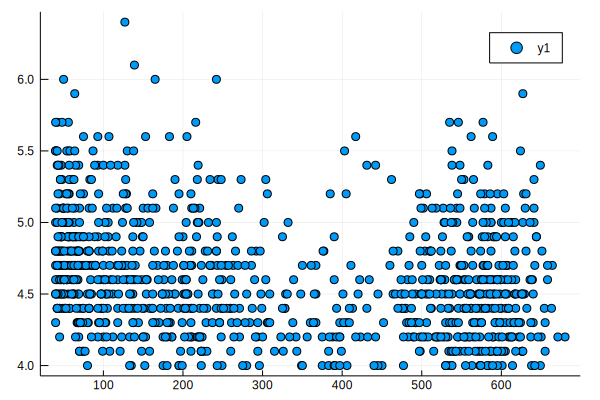

In [22]:
scatter(depth,mags)

In [13]:
describe(mags)

Summary Stats:
Mean:           4.620400
Minimum:        4.000000
1st Quartile:   4.300000
Median:         4.600000
3rd Quartile:   4.900000
Maximum:        6.400000
Length:         1000
Type:           Float64


In [4]:
mags = Float64.(quakes[:Mag]);
(m1, m2, m3, m4) = map(x -> round(x,digits=4), 
              [mean(mags), std(mags), skewness(mags), kurtosis(mags)]);

In [5]:
using Printf
@printf "Mean: %.4f\nStdV: %.4f\nSkew: %.4f\nKurt: %.4f\n" m1 m2 m3 m4

Mean: 4.6204
StdV: 0.4028
Skew: 0.7686
Kurt: 0.5103


In [24]:
histmag = fit(Histogram, mags, 4.0:0.1:6.6, closed=:left)

Histogram{Int64,1,Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}}
edges:
  4.0:0.1:6.6
weights: [46, 55, 90, 85, 101, 107, 101, 98, 65, 54  …  9, 8, 0, 2, 3, 1, 0, 0, 1, 0]
closed: left
isdensity: false

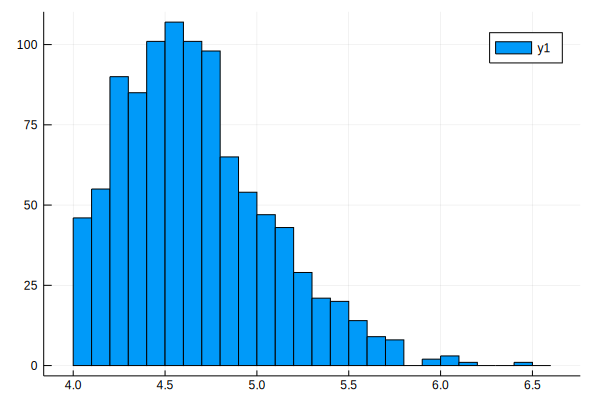

In [25]:
plot(histmag)

---

## Statistics


In [75]:
using RDatasets

mlmf = dataset("mlmRev","Gcsemv");
size(mlmf)

(1905, 5)

In [76]:
mlmf[1:5,:]

,School,Student,Gender,Written,Course
,Categorical…,Categorical…,Categorical…,Float64⍰,Float64⍰
1,20920,16,M,23.0,missing
2,20920,25,F,missing,71.2
3,20920,27,F,39.0,76.8
4,20920,31,F,36.0,87.9
5,20920,42,M,16.0,44.4


In [77]:
describe(mlmf)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Union…,DataType
1,School,,20920,,84772,73,,CategoricalString{UInt8}
2,Student,,1,,5521,649,,CategoricalString{UInt16}
3,Gender,,F,,M,2,,CategoricalString{UInt8}
4,Written,46.3652,0.6,46.0,90.0,,202,Float64
5,Course,73.3874,9.25,75.9,100.0,,180,Float64


In [78]:
writtenF = collect(skipmissing(mlmf[mlmf.Gender .== "F", :Written]));
writtenM = collect(skipmissing(mlmf[mlmf.Gender .== "M", :Written]));

In [84]:
 (μWM, μWF) = round.((mean(writtenM), mean(writtenF)), digits=3)

(48.286, 45.005)

In [87]:
(σWM, σWF) = round.((std(writtenM), std(writtenF)),digits=3)

(12.905, 13.535)

In [81]:
(nWM, nWF) = (length(writtenM), length(writtenF))

(706, 997)

In [82]:
σW = sqrt((σWM*σWM)/(nWM - 1) + (σWF*σWF)/(nWF - 1))
tt = round(abs(σWM - σWF)/σW , digits=4)    

# p ~ 0.33; 95% ~ 0.06, 90% ~ 0.13

0.9726

---

## Distributions

In [40]:
using Distributions, StatsBase
[round(f(Poisson(2.2)) , digits=4)
    for f in [mean, std, median, skewness, kurtosis]]

5-element Array{Float64,1}:
 2.2   
 1.4832
 2.0   
 0.6742
 0.4545

In [43]:
using Printf
for i = 0:7
  pf = pdf(Poisson(2.2), i)
  cf = cdf(Poisson(2.2), i)
  @printf "%d : %7.4f %7.4f\n"  i  pf  cf
end

0 :  0.1108  0.1108
1 :  0.2438  0.3546
2 :  0.2681  0.6227
3 :  0.1966  0.8194
4 :  0.1082  0.9275
5 :  0.0476  0.9751
6 :  0.0174  0.9925
7 :  0.0055  0.9980


In [45]:
rand(Poisson(2.2),15)'  # Output the transpose to reduce space

1×15 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 0  4  1  4  1  4  1  1  1  2  4  3  4  2  2

In [46]:
fit(Poisson, rand(Poisson(2.2),1000))

Poisson{Float64}(λ=2.177)

### Kernel density

In [89]:
using RDatasets, KernelDensity

In [90]:
mlmf = dataset("mlmRev", "Gcsemv");

In [91]:
df = mlmf[completecases(mlmf[[:Written, :Course]]), :]

,School,Student,Gender,Written,Course
,Categorical…,Categorical…,Categorical…,Float64⍰,Float64⍰
1,20920,27,F,39.0,76.8
2,20920,31,F,36.0,87.9
3,20920,42,M,16.0,44.4
4,20920,101,F,49.0,89.8
5,20920,113,M,25.0,17.5
6,22520,1,F,48.0,84.2
7,22520,7,M,46.0,66.6
8,22520,9,F,28.0,47.2
9,22520,15,F,43.0,80.5


In [92]:
size(mlmf)

(1905, 5)

In [95]:
macro F64(sym)
    quote
      Float64.(skipmissing(Array($sym)))
    end
end

@F64 (macro with 1 method)

In [100]:
dc = @F64 df[:Course];
dw = @F64 df[:Written];

In [101]:
kdc = kde(dc)

UnivariateKDE{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}(-4.413927934889138:0.057683368768821824:113.66392793488913, [6.29918e-7, 5.9931e-7, 5.71447e-7, 5.46211e-7, 5.23495e-7, 5.032e-7, 4.85234e-7, 4.69516e-7, 4.55972e-7, 4.44534e-7  …  1.11998e-6, 1.0532e-6, 9.90931e-7, 9.32933e-7, 8.78992e-7, 8.28902e-7, 7.82472e-7, 7.39521e-7, 6.99882e-7, 6.63396e-7])

In [114]:
summarystats(dc)

Summary Stats:
Mean:           73.381385
Minimum:        9.250000
1st Quartile:   62.900000
Median:         75.900000
3rd Quartile:   86.100000
Maximum:        100.000000


In [103]:
kdw = kde(dw)

UnivariateKDE{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}(-10.566838284615796:0.054584111660591884:101.16683828461579, [6.29167e-8, 6.34892e-8, 6.44332e-8, 6.57534e-8, 6.74563e-8, 6.95498e-8, 7.20435e-8, 7.49489e-8, 7.8279e-8, 8.20486e-8  …  7.77206e-8, 7.44889e-8, 7.16687e-8, 6.92488e-8, 6.72196e-8, 6.55732e-8, 6.43033e-8, 6.34051e-8, 6.28754e-8, 6.27126e-8])

In [104]:
summarystats(dw)

Summary Stats:
Mean:           46.502298
Minimum:        0.600000
1st Quartile:   38.000000
Median:         46.000000
3rd Quartile:   56.000000
Maximum:        90.000000


In [92]:
using PyPlot

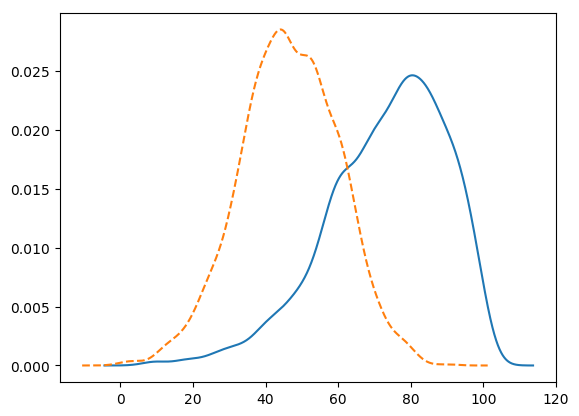

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x131e40c10>

In [99]:
PyPlot.plot(kdc.x, kdc.density)
PyPlot.plot(kdw.x, kdw.density, linestyle="--")

In [115]:
for subdf in groupby(df, :School)
  (size(subdf)[1] > 40) &&  
    let
     sch = subdf[:School][1]
     msw = mean(subdf[:Written]) 
     msc = mean(subdf[:Course])
     nsz = size(subdf)[1]
     @printf "%10s : %8.4f %8.4f %3d\n" sch msw msc nsz
    end
end

     22520 :  35.4482  57.4580  56
     60457 :  53.4773  85.9568  44
     68107 :  44.9107  74.6750  56
     68125 :  47.1556  77.5322  45
     68137 :  28.2807  62.5373  83
     68411 :  40.4615  59.4369  65
     68809 :  42.7705  71.1115  61


---

In [118]:
using HypothesisTests

df68107 = mlmf[mlmf[:School] .== "68107", :];
df68107cc = df68107[completecases(df68107[[:Written, :Course]]), :];

df68411 = mlmf[mlmf[:School] .== "68411", :];
df68411cc = df68411[completecases(df68411[[:Written, :Course]]), :];


┌ Info: Precompiling HypothesisTests [09f84164-cd44-5f33-b23f-e6b0d136a0d5]
└ @ Base loading.jl:1189


In [119]:
df68107wri = @F64 df68107cc[:Written];
df68411wri = @F64 df68411cc[:Written];

UnequalVarianceTTest(df68107wri, df68411wri)


Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          4.449175824175825
    95% confidence interval: (-0.1837, 9.082)

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.0596

Details:
    number of observations:   [56,65]
    t-statistic:              1.9032531870995715
    degrees of freedom:       109.74148002018097
    empirical standard error: 2.337668920946911


In [120]:
df68107cou = @F64 df68107cc[:Course];
df68411cou = @F64 df68411cc[:Course];

UnequalVarianceTTest(df68107cou, df68411cou)

Two sample t-test (unequal variance)
------------------------------------
Population details:
    parameter of interest:   Mean difference
    value under h_0:         0
    point estimate:          15.238076923076903
    95% confidence interval: (10.6255, 19.8506)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-8

Details:
    number of observations:   [56,65]
    t-statistic:              6.541977424916656
    degrees of freedom:       118.13175559744462
    empirical standard error: 2.329276904111456


---

In [116]:
using GLM

┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1189


In [121]:
dw68411ss =  sort(sample(df68411wri,50));
dw68107ss =  sort(sample(df68107wri,50));
dc68411ss =  sort(sample(df68411cou,50));
dc68107ss =  sort(sample(df68107cou,50));

In [131]:
macro rdup(val, dgt)
  quote 
    round.($val, digits=$dgt)
  end
end

@rdup (macro with 1 method)

In [129]:
@rdup cor(dw68107ss, dw68411ss) 3

0.984

In [133]:
@rdup cor(dc68107ss, dc68411ss) 3

0.993

In [142]:
dwf = convert(DataFrame, hcat(dw68107ss, dw68411ss))
names!(dwf, [:s68107, :s68411])

dwf[1:5,:]

,s68107,s68411
,Float64,Float64
1,18.0,16.0
2,22.0,23.0
3,22.0,28.0
4,22.0,29.0
5,22.0,29.0


In [143]:
dcf = convert(DataFrame, hcat(dc68107ss, dc68411ss))
names!(dcf, [:s68107, :s68411])

dcf[1:5, :]

,s68107,s68411
,Float64,Float64
1,47.2,32.4
2,47.2,32.4
3,50.0,32.4
4,55.5,32.4
5,55.5,37.0


In [152]:
lm1 = fit(LinearModel, @formula(s68107 ~ s68411), dwf)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: s68107 ~ 1 + s68411

Coefficients:
             Estimate Std.Error  t value Pr(>|t|)
(Intercept)  -4.79368   1.81815 -2.63657   0.0112
s68411        1.17445 0.0439365  26.7307   <1e-29


In [150]:
lm2 = fit(LinearModel, @formula(s68107 ~ s68411), dcf)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: s68107 ~ 1 + s68411

Coefficients:
             Estimate Std.Error t value Pr(>|t|)
(Intercept)   19.7128   2.10054 9.38461   <1e-11
s68411       0.945694 0.0359333 26.3181   <1e-29


---

## Time Series

In [1]:
using TimeSeries, MarketData

┌ Info: Recompiling stale cache file /Users/malcolm/.julia/compiled/v1.0/MarketData/vKuMd.ji for MarketData [945b72a4-3b13-509d-9b46-1525bb5c06de]
└ @ Base loading.jl:1187


In [7]:
# Two years of AAPL data (for 2000 / 2001)

ohlcv[1:5]

5×5 TimeArray{Float64,2,Date,Array{Float64,2}} 2000-01-03 to 2000-01-07
│            │ Open   │ High   │ Low    │ Close  │ Volume   │
├────────────┼────────┼────────┼────────┼────────┼──────────┤
│ 2000-01-03 │ 104.88 │ 112.5  │ 101.69 │ 111.94 │ 4.7839e6 │
│ 2000-01-04 │ 108.25 │ 110.62 │ 101.19 │ 102.5  │ 4.5748e6 │
│ 2000-01-05 │ 103.75 │ 110.56 │ 103.0  │ 104.0  │ 6.9493e6 │
│ 2000-01-06 │ 106.12 │ 107.0  │ 95.0   │ 95.0   │ 6.8569e6 │
│ 2000-01-07 │ 96.5   │ 101.0  │ 95.5   │ 99.5   │ 4.1137e6 │

In [18]:
#=
struct TimeArray{T,N,D<:TimeType,A<:AbstractArray{T,N}} <: AbstractTimeSeries{T,N,D}
    timestamp::Vector{D}
    values::A   # an AbstractArray{T,N}
    colnames::Vector{Symbol}
    meta::ANY
end

=#

meta(ohlc)    # ohlc does not include the volume (v)

"AAPL"

In [28]:
colnames(ohlc)

4-element Array{Symbol,1}:
 :Open 
 :High 
 :Low  
 :Close

In [40]:
timestamp(ohlc)[end-2:end]

3-element Array{Date,1}:
 2001-12-27
 2001-12-28
 2001-12-31

In [39]:
values(ohlc)[end-2:end]

3-element Array{Float64,1}:
 22.07
 22.43
 21.9 

In [21]:
cl[1:3]   # Also op, hi, lo

3×1 TimeArray{Float64,1,Date,Array{Float64,1}} 2000-01-03 to 2000-01-05
│            │ Close  │
├────────────┼────────┤
│ 2000-01-03 │ 111.94 │
│ 2000-01-04 │ 102.5  │
│ 2000-01-05 │ 104.0  │

In [23]:
using PyPlot

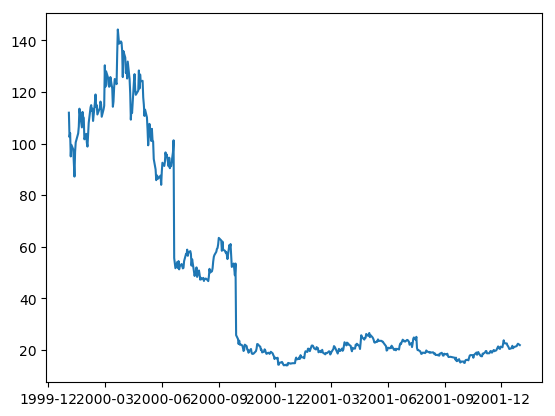

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x129d6ad90>

In [25]:
PyPlot.plot(timestamp(cl),values(cl))

In [38]:
# Marketdata used to provide routines for getting data from Yahoo (no-defunct)
# Also from FRED (Federal Reserve Bank of St Louis), for US economic data
# see: https://fred.stlouisfed.org
#
# As with the ohlc dataset fred() returns a default series, the US CPI
# 
cpi =  fred()
vcat(cpi[1:3],cpi[end-2:end])

6×1 TimeArray{Float64,2,Date,Array{Float64,2}} 1913-01-01 to 2018-09-01
│            │ VALUE   │
├────────────┼─────────┤
│ 1913-01-01 │ 9.8     │
│ 1913-02-01 │ 9.8     │
│ 1913-03-01 │ 9.8     │
│ 2018-07-01 │ 252.006 │
│ 2018-08-01 │ 252.146 │
│ 2018-09-01 │ 252.439 │

In [41]:
dsg10 = fred("DGS10")
vcat(dsg10[1:3],dsg10[end-2:end])

6×1 TimeArray{Float64,2,Date,Array{Float64,2}} 1962-01-02 to 2018-11-08
│            │ VALUE │
├────────────┼───────┤
│ 1962-01-02 │ 4.06  │
│ 1962-01-03 │ 4.03  │
│ 1962-01-04 │ 3.99  │
│ 2018-11-06 │ 3.22  │
│ 2018-11-07 │ 3.22  │
│ 2018-11-08 │ 3.24  │

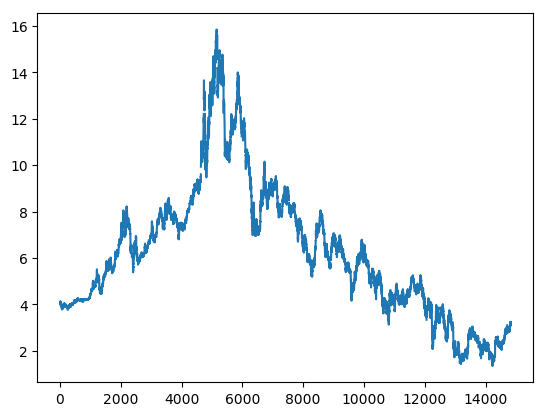

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12956cf90>

In [34]:
t = collect(1:length(dsg10))
y = values(dsg10)
PyPlot.plot(t,y)

---

In [1]:
# Temporal.jl is an alternative timeseries package, maintained by JuliaQuant
# and integrating with some packages from the group, such as Quandl and Indicators
# which we will meet later in the book
#
# * Motivated by the `xts` package in R and the `pandas` package in Python *
#
using Temporal, MarketData

In [4]:
md = MarketData   # Ensure no name clash on 'ohlc'
aaplts = TS(values(md.ohlc),timestamp(md.ohlc),colnames(md.ohlc))

500x4 TS{Float64,Date}: 2000-01-03 to 2001-12-31

Index       Open    High    Low     Close   
2000-01-03  104.88  112.5   101.69  111.94  
2000-01-04  108.25  110.62  101.19  102.5   
2000-01-05  103.75  110.56  103.0   104.0   
2000-01-06  106.12  107.0   95.0    95.0    
2000-01-07  96.5    101.0   95.5    99.5    
2000-01-10  102.0   102.25  94.75   97.75   
2000-01-11  95.94   99.38   90.5    92.75   
2000-01-12  95.0    95.5    86.5    87.19   
2000-01-13  94.48   98.75   92.5    96.75   
2000-01-14  100.0   102.25  99.38   100.44  
2000-01-18  101.0   106.0   100.44  103.94  
⋮
2001-12-12  21.87   21.92   21.25   21.49   
2001-12-13  21.49   21.55   20.5    21.0    
2001-12-14  20.73   20.83   20.09   20.39   
2001-12-17  20.4    21.0    20.19   20.62   
2001-12-18  20.89   21.33   20.22   21.01   
2001-12-19  20.58   21.68   20.47   21.62   
2001-12-20  21.4    21.47   20.62   20.67   
2001-12-21  21.01   21.54   20.8    21.0    
2001-12-24  20.9    21.45   20.9    21.36   
200

In [41]:
using Printf
aapl_spread = aaplts[:High] - aaplts[:Low]
@printf "Average spread : %.3f\n" round(sum(aapl_spread)/length(aapl_spread), digits=3)

Average spread : 2.877


In [58]:
describe(aapl_spread.values[:,1])

Summary Stats:
Mean:           2.876540
Minimum:        0.380000
1st Quartile:   0.940000
Median:         1.500000
3rd Quartile:   4.007500
Maximum:        16.250000
Length:         500
Type:           Float64


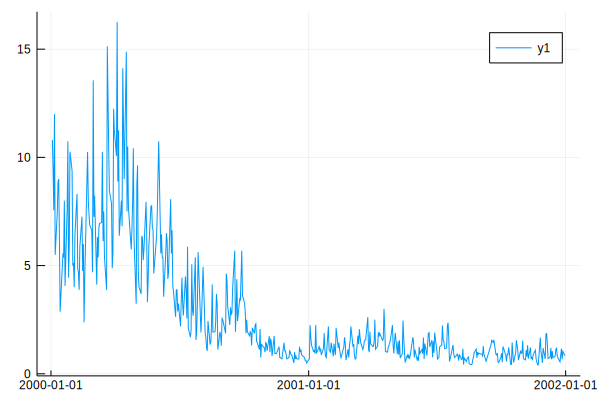

In [60]:
plot(aapl_spread.index,aapl_spread.values[:,1])